## Autoencoder

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” Autoencoders can be used for image denoising, image compression, and, in some cases, even generation of image data.

## Flow of Autoencoder

Noisy Image -> Encoder -> Compressed Representation -> Decoder -> Reconstruct Clear Image

## Import Modules

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input
from keras.datasets import mnist

# Enable GPU

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [12]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

# Download the latest version of the CelebA dataset
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# print("Path to dataset files:", path)
path = "/Users/yfahmy/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/"

# Path to the directory where the CelebA images are stored
base_dir = os.path.join(path, "img_align_celeba")  # Adjust if needed

# Image size to resize all images to
image_dim = 200

# Initialize a list to hold image data
images = []

# Optional: limit number of images if needed
MAX_IMAGES = 10000

# Loop through images in the dataset directory
for i, filename in enumerate(os.listdir(base_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(base_dir, filename)

        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize((image_dim, image_dim))
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

        if i + 1 >= MAX_IMAGES:
            break

# Convert list to numpy array
images = np.array(images)

# Split into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Ensure the correct shape for TensorFlow (batch, height, width, channels)
x_train = x_train.reshape(len(x_train), image_dim, image_dim, 3)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, 3)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (8000, 200, 200, 3), x_test shape: (2000, 200, 200, 3)


## Add Gaussian Noise

In [13]:
noise_factor = 0.075
# Gaussian Noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

## Add Salt and Pepper Noise

In [14]:
def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
    N, H, W, C = images.shape
    rand_matrix = np.random.rand(N, H, W)
    salt_mask = rand_matrix < salt_prob
    pepper_mask = rand_matrix > (1 - pepper_prob)
    images[salt_mask] = 255
    images[pepper_mask] = 0
    return images

x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

In [15]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

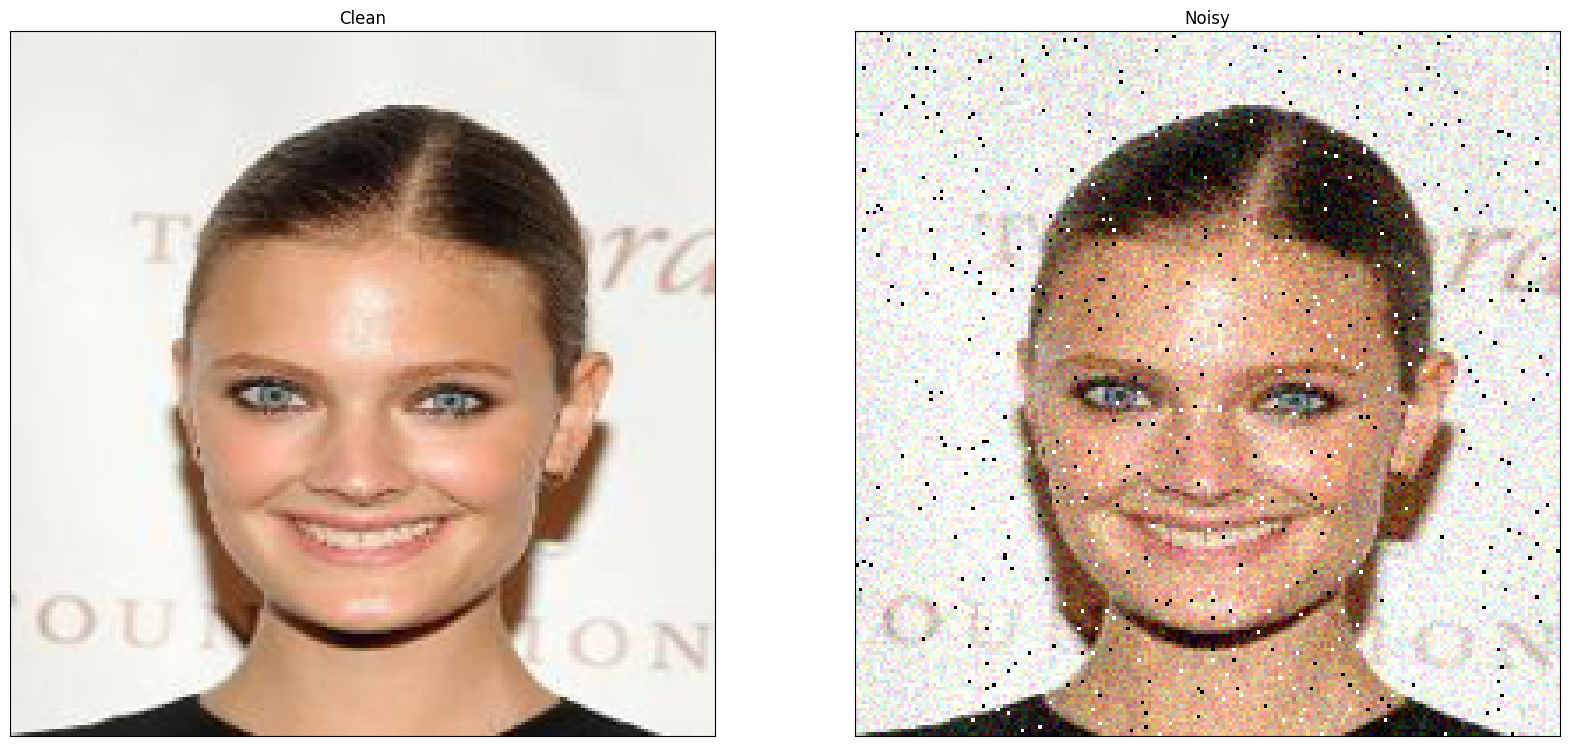

In [19]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 2, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
plt.show()

## Model Creation

In [21]:
input_img = Input(shape=(image_dim, image_dim, 3))  # RGB images

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

for _ in range(6): 
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Last layer (Conv, No Activation)
x = Conv2D(3, (3, 3), padding='same')(x)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 200, 200,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 200, 200,  │          0 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_11[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_13[0][0] 

 Total params: 226,627 (885.26 KB)

 Trainable params: 225,859 (882.26 KB)

 Non-trainable params: 768 (3.00 KB)

In [22]:
# train the model
model.fit(x_train_noisy, x_train, epochs=100 , batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/100


2025-03-21 17:37:16.297265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-21 17:37:16.307931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1406

2025-03-21 17:42:46.910796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


125/125 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - loss: 0.1399 - val_loss: 0.0125
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - loss: 0.0083 - val_loss: 0.0104
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - loss: 0.0051 - val_loss: 0.0080
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - loss: 0.0037 - val_loss: 0.0044
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0023 - val_loss: 0.0027
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0018 - val_loss: 0.0022
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0015 - val_loss: 0.0016
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 

## Visualize the Results

In [23]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

2025-03-22 02:46:58.719137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056019783..1.0402675].


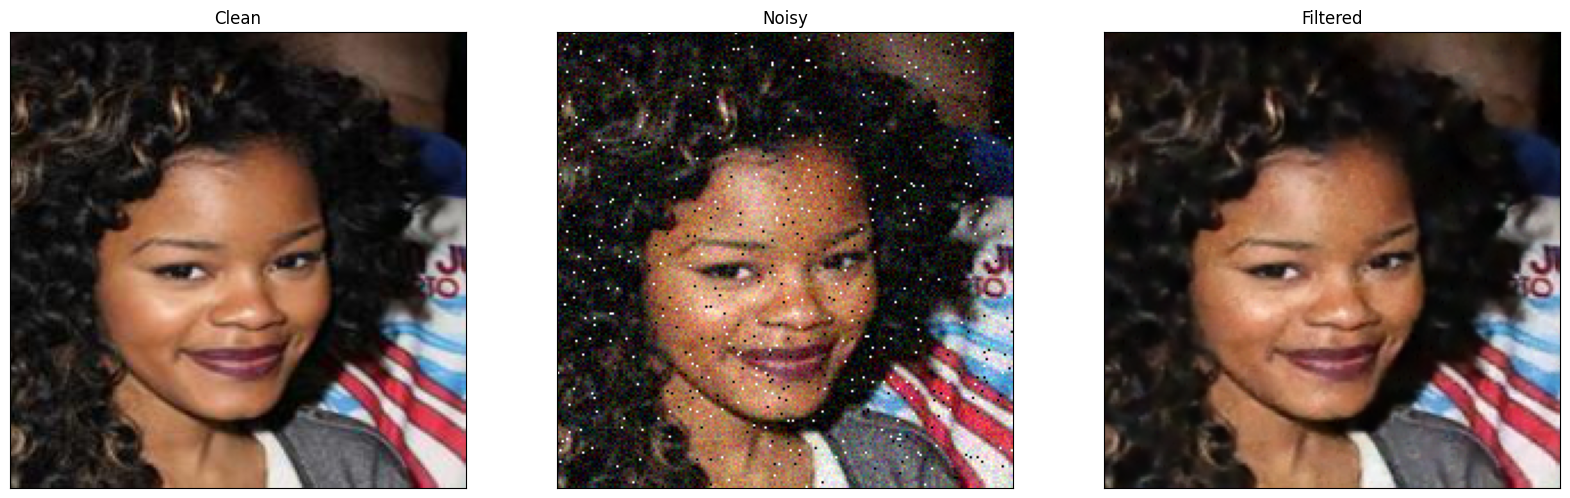

In [27]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()